# Tipos de entrenamiento 

En la unidad anterior se ha visto un ejemplo de entrenamiento de un par de modelos sencillos a mayores con estos podemos pasarle nuevos elementos y hacer predicciones ya sea sobre la clase o estimar algun valor en una regresión. 

Uno de los puntos donde no se ha prestado mucha atención en ese proceso es como se realiza el entrenamiento.En está unidad vermos la necesidad de realizar diferentes esquemas de reparto para el entrenamiento con el fin de obtener mejores modelos. 

En las próximas secciones se vera, en un proceso incremental de complejidad la necesidad de prestar atención el porqué se necesitan varios conjuntos de datos y los diferentes esquemas disponibles, así como cuando es mejor usar unos  u otros.

## Carga de los datos
En está ocasión, en lugar de usar una de las bases de datos preparadas por `scikit-learn`, cargaremos los datos desde un archivo CSV. Esto lo podremos realizar con el siguiente código:

In [ ]:
from rich import print
import os.path
import pandas as pd

def load_data(folder, file_name, url):
    #Comprobar si existe la carpeta, si no crearla
    if not os.path.exists(folder):
        os.mkdir(folder)
        
    #comprobar si existe el fichero y si no descargarlo
    name = os.path.join(folder, file_name)   
    if not os.path.isfile(name):
        print(f'Downloading'.ljust(75,'.'), end='', flush=True)
        import urllib.request
        urllib.request.urlretrieve(url,name)
        print(f"Done!")
    return pd.read_csv(name, delimiter=',', header=None)

# Datos generales
data_folder = '_data_'
file_name = 'sonar.all_data'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'

# Cargar los datos
data = load_data(data_folder,file_name, url)

# Mostrar los 5 primeros patrones
data.head(5)

En el código anterior se han definido una función load_data que nos permitirá descargar el archivo si aun no lo tenemos en un directorio local `_data_`. Una vez hecho eso lo que se hace es cargar los datos en una estructura conocida como *Dataframe* que en *Python* se puede usar con la librería `pandas`. Esta estructura es similar a una tabla de una base de datos y facilita la consulta de los mismos. Para nuestra suerte esta librería usa internamente otra librería `numpy` la cual es la usada en *Python* para la gestión de matrices de manera eficiente. Esta última es la necesaria para poder operar con `scikit-learn` por lo que no es necesario hacer la conversión a este formato es trivial como se verá. 

El problema en cuestión que estamos cargando es el que seinformalmente como **¿Roca o Mina?**. Se trata de una base de datos pequeña que consta de 111 patrones correspondientes a rocas y 97 a minas acuaticas (simuladas como cilindros metálicos). Cada uno de los patrones consta de 60 medidas (variables) numérica entre 0.0. y 1.0. Esas medidas se corresponden con el valor de la energia de diferentes rangos de longitud de onda para un cierto periodo de tiempo. A mayores, la columna 61 se corresponde con la salida deseada que, en este caso concreto se ha representado con una letra 'R' o 'M' segun el tipo. Dada esta situación vamos a preparar los datos tanto de entrada como de salida. 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

#Recoger las 60 primeras mediciones y convertirlas a un Numpy
#no tienen nombre así que accedemos según la posición
inputs = (data.iloc[:,0:60]).to_numpy()

#Convertir la salida a un Numpy y formato numérico
targets = (data[60]=='M').to_numpy().astype('int')

assert inputs.shape[0] == len(targets), "Los patrones no se han cargado correctamente ya que no estan alineadas entrada y salida"
print(f"Patrones disponibles {inputs.shape} -> {targets.shape}")

#Crear los conjuntos de entrenamiento y test
#train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.1, stratify=outputs)

#print(f"Train Patterns{train_inputs.shape} -> {train_outputs.shape}")
#print(f"Test Patterns{test_inputs.shape} -> {test_outputs.shape}")

## Entrenar el modelo con todos los datos disponibles
La primera tentación que podríamos tener es entrenar los modelos con todos los datos disponibles, por ejemplo, en el siguiente fragmento de código entrenaremos un modelo conocido como KNN (*K-nearest neighbours*) con todos los datos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# definición del modelo
ml_knn = KNeighborsClassifier()

# entrenamiento del modelo
ml_knn.fit(inputs,targets)
#Uso del modelo
ml_knn_predictions = ml_knn.predict(inputs)
print(ml_knn_predictions)

Una vez entrenado, se ha usado el modelo resultante para predecir las mismas entradas. Con el resultado que se ve a continuación: 

In [ ]:
from sklearn import metrics
print(f"Accuracy del modelo: {metrics.accuracy_score(targets,ml_knn_predictions)*100:.2f}% ")

**PREGUNTA: ¿Podemos saber que el modelo lo ha hecho bien?**
Realmente no, al no disponer de una parte de los datos con las que validar el funcionamiento del modelo que no se hayan usado para ajustar la verdad que no sabemmos como de generales son las relaciones. Por ello, uno de los primeros pasos y que ya se aplico en la unidad Introductoria es la división de los datos en dos sub conjuntos, uno para entrenar el modelo,  y otro para validarlo. Este último nos permitirá evaluar la capacidad de generalización del modelo al ver su rendimiento con datos desconocidos. De ese punto vendrá nuestra primera mejora.

## Dividir los datos en training y test

Una priemra aproximación que es netamente mejor consiste en dividir nuestro conjunto de datos inicial en dos conjuntos, uno se usará para entrenar el modelo y otro se dejará fuera de todo el proceso (desconocido para el modelo). Este procedimeinto conocido por su voz inglesa, *hold-out*, permite contar con un conjunto de datos que no ha sido visto por el modelo para comprobar la capacidad de generalización del mismo usando datos desconocidos.
Para realizar dicha división, `scikit-learn` cuanta con un método que se ha empleado en la unidad anteirior como es `train_test_split`, el cual se puede aplicar de la siguiente manera:

In [ ]:
from sklearn.model_selection import train_test_split

inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=0.2,stratify=targets,random_state=42)

**PREGUNTA: ¿para qué sirve el parámetro stratify? y ¿el parámetro random_state?**

Este es el típico parámetro que se ve mejor con un ejemplo:

In [ ]:
print(f"Si los datos globales son {inputs.shape} es decir {inputs.shape[0]} patrones con {inputs.shape[1]} variables.")
print(f"El 80% de los patrones es {0.8*inputs.shape[0]}, que se corresponde con el número de patrones de entranamiento redondeado {inputs_train.shape}")
print(f"Mientras el 20% restante de los patrones es {0.2*inputs.shape[0]}, que se corresponde con el número de patrones de test {inputs_test.shape}")

Sin embargo, como son esos patrones, tenemos dos clases diferentes en el *dataset*, Mina y Roca, que no están en la misma proporción. El parámetro stratify nos permite hacer que los dos conjuntos tengan aproximadamente las mismas proporciones. Veamos:

In [ ]:
print(f"Conteo global: {np.unique(targets,return_counts=True)}")
print(f"Conteo entrenamiento: {np.unique(targets_train,return_counts=True)}")
print(f"Conteo test: {np.unique(targets_test,return_counts=True)}")

In [ ]:
from sklearn.model_selection import train_test_split

inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=0.2)
np.unique(targets_test,return_counts=True)

Lo normal es que al no garantizar las salidas proporcionales al conjunto de entrada el entrenamiento se desvirtue ya que el conjunto de entranamiento puede que no este representando la proporción real que posteriormente el modelo encontraría en una hipotética puesta en producción. 

**PREGUNTA: ¿cuál es el proceso real que ha hecho la función `train_test_split`?. Es decir, si os dijese que hay que implementarlo, ¿qué tendriamos que hacer?**

Vamos a compara el resultdo de la versión implementada por `sckit-learn` y una propia. 

### ¿Qué estamos haciendo realmente?
Implementemos nuestra función de split:

In [ ]:
import numpy as np
import pandas as pd

def own_split_train_test(inputs,target,ratio):
    indices = np.random.permutation(len(inputs))
    test_set_size = round(int(len(inputs)*ratio))
    indices_test = indices[:test_set_size]
    indices_train = indices[test_set_size:]
    return inputs[indices_train], inputs[indices_test], targets[indices_train], targets[indices_test]

Ahora procederemos a dividir los datos con nuestra función recien definida.

In [ ]:
my_inputs_train, my_inputs_test, my_targets_train, my_targets_test = own_split_train_test(inputs, targets ,ratio=0.2)

print(f"{my_inputs_train.shape} -> {my_targets_train.shape}")
print(f"{my_inputs_test.shape} -> {my_targets_test.shape}")

Como podemos ver la distribución es la misma, bueno, salvo por una discrepacia de 1.

**PREGUNTA: ¿Que puede no ser correcto del código que acabamos de ver?**

Cada vez que se llama a nuestra función, devolverá un conjunto de test diferente. Este no es un comportamiento deseable para poder repetir y comparar experimentos. Si entrenamos suficientes veces (muchas) el modelo de ML podemos estar introduciendo un sesgo y ajustar demasiado los modelos a los conjuntos que nos interesan. Este es el motivo por el que la función de `scikit-learn` añade *random_state*, que por defecto tiene el valor `None`. A veces se ven opciones del tipo random_state=42 para poder repetir el experimento. El número 42 no tiene nada de especial, pero de alguna manera se ha convertido tradicionalmente en el que se usa.

En este sentido puede ser de utilidad el hecho de que en un entorno interactivo e incluso en jupyter o en consola, si se desea obtener información de una función, en Python, se puede emplear las siguientes sentencias.

In [ ]:
import inspect
lines = inspect.getsource(train_test_split)
print(lines)

Por tanto,  cones e parámetro apra la división de los datos podemos repetir la misma dividión para comprobarlo vamos a entrenar 2 veces repitiendo la división y sin repetirla. Es más, no lo vamos a hacer con un modelo si no con 30 modelos diferentes. El modelo KNN tiene un parámtro que indica cuantos vecinos tiene en cuenta para asignarle la clase a un nuevo patrón. Lo podríamos hacer a mano pero igual es mejor con un bucle. 

In [ ]:
# Función para ejecutar tanto los entrenamientos como pintar la gráfica
def entrenar_y_dibujar(inputs_train,inputs_test, targets_train, targets_test):
    hiper_k_rango = range(1,30)
    scores_train=[]
    scores_test=[]
    for k in hiper_k_rango:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(inputs_train,targets_train)
        predicted_train = knn_model.predict(inputs_train)
        predicted_test = knn_model.predict(inputs_test)
        scores_train.append(metrics.accuracy_score(targets_train, predicted_train))
        scores_test.append(metrics.accuracy_score(targets_test,predicted_test))

    print(scores_test)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()

    plt.plot(hiper_k_rango,scores_train, color='orange')
    plt.plot(hiper_k_rango,scores_test, color='navy')

    plt.xlabel("Valores de k")
    plt.ylabel("Accuracy en test")


In [ ]:
#primera repetición
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)
entrenar_y_dibujar(inputs_train, inputs_test, targets_train, targets_test)

In [ ]:
#segunda repetición
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)
entrenar_y_dibujar(inputs_train, inputs_test, targets_train, targets_test)

In [ ]:
#con un split diferente
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)
entrenar_y_dibujar(inputs_train, inputs_test, targets_train, targets_test)

En términos generales:
* Vemos que al coincidir el estado del spit los resultados son replicables, 
* El accuracy disminuye cuando se incrementa la complejidad.
* Los modelos muy complejos para los datos analizados son penalizados severamente en el accuracy de test

**PREGUNTA: ¿por qué?** En general cuando se incrementa la complejidad del modelo no implica que este pueda resolver mejor el problema plantedo, todo lo contraría este tiende al sobreajuste (*overfitting*) o al subajuste (*underfitting*). 
**PREGUNTA: Supongase que  que ahora mismo hemos seguido la mejor aproximación posible para entrenar un modelo de ML.¿qué modelo pondríamos en producción?** La respuesta a esta pregunta debiera de ser el modelo más sencillo entre aquellos que han alcanzaddo los mejores resultdaos en test.
Aun así vemos una cosa y es que no todas las particiones tienen los mismos resultados aun con los mismos individuos, es decir somos dependientes de que hemos escogido como test y que hemos escogido como conjunto de entrenamiento. Este hecho nos llevará al siguiente punto que el el Además vemos la diferencia entre las dos pruebas con particiones, y que nos llevará al siguiente concepto que es el * k-fold cross-validation* tratando de paliar este punto.
Eso quiere decir que *hold-out* no sirve para nada, para nada, si tengo suficientes datos no sería preciso el usar otro tipo de metodos, aunque se ha demostrado con un *sampling* puramente aleatorio que tenemos entorno al 20% de posibilidades de introducir un sesgo debido a la división de los datos. 

Por tanto, cuando usar este tipo de aproximación, en primer lugar cuando queramos hacer alguna prueba rápida, este siempre será menos costoso computacionalmente que los esquemas que veremos a continuación. O bien, cuando tengamos tamaños muestrales grandes en el que esta cuasi-garantizada la diversidad entre los dos subconjuntos.

## k-fold cross-validation
Una vez vistas las limitaciones del reparto de las observaciones en dos conjuntos (entrenamiento y test), vamos a ver una mejor aproximación que va a permitir a los modelos generalizar en condiciones más estables y seguras o al menos tomar una decisión más informada por nuestra parte con mayor confianza. 

Vamos a realizar un *K-fold Cross-validation*, en este caso seguiremos los siguientes pasos:

1. Divide el dataset en **k** grupos de igual tamaño
2. Usa el primer fold para test y todos los demás juntos para entrenar el modelo
3. Calcula el accuracy en test
4. Repite los pasos 2 y 3 **k** veces, utilizando como fold de validación una vez cada uno de los folds
4. Calcula el rendimiento global al final del proceso. Existen dos aproximaciones:
    + hacer la media de todos los folds
    + una aproximación más purista o respetuosa con el ML extraería la salida esperada y la salida predicha (vectores) de cada uno de los folds, reconstruiría el *vector grande* y calcularía el resultado.
 
El esquema de este procedimiento sería como en el gráfico siguiente

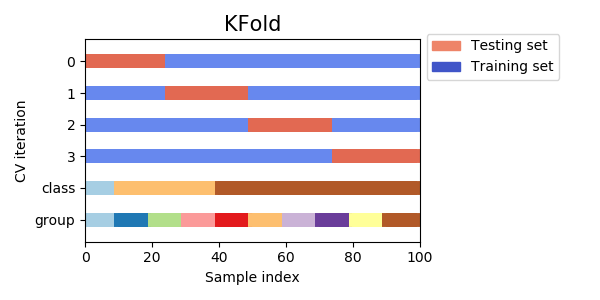
Por lo tanto, cada uno de los posibles datos dentro del dataset se usa al menos una vez en el test y el valor extraido representará como se comporta el sistema con todo el conjunto reduciendo, por lo tanto, el sesgo debido a la selección.

Para hacer esto, `scikit-learn` también nos ofrece utilidades que simplifican mucho el trabajo mediante la clase KFold, vemaos un ejemplo con numeros secuenciales:

In [ ]:
from sklearn.model_selection import KFold
X = np.random.rand(30,10)
y = np.random.rand(30,1)
kf = KFold(n_splits=5)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]


**PREGUNTA: ¿le veis algún problema?**
Efectivamente, los datos son correlativos, deberemos de indicar que queremos que no los baraje ya que en otro caso podríamos tener que todos los patrones de una clase caerían en la misma partición siendo esta poco representativa del total. Para ello, la función `KFold` tiene un parámetro `shuffle` que nos dará el comportameinto deseado.

In [ ]:
from sklearn.model_selection import KFold
X = np.random.rand(30,10)
y = np.random.rand(30,1)
kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

Procedamos ahora a realizar el primer *cross-validation*, en este caso es uno de los más habituales un *10-fold cross-validation* o 10-cv para abreviar. A mayores en lugar de aplicar nosotros con un bucle cada uno de los conjuntos y tener que llevar el conteo hacer las medias, etc. `scikit-learn` cuenta también con una función `cross_val_score` que automatiza todo el proceso encapsulándolo en una sencilla llamada a función. Un punto a destacar de esta función es que, en el parámetro `cv`, puede recibir bien unn numero para hacer un KFold, un objeto de reparto predefinido como vemos más tarde o las listas directamente.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn_model = KNeighborsClassifier()

resultados_kfold = cross_val_score(knn_model,inputs,targets,cv=10,scoring='accuracy')
print(f"Los resultados para las 10 particiones son: {resultados_kfold}")
print(f"Es decir, tiene un resultado de: {resultados_kfold.mean()} +/- {resultados_kfold.std()}")

Idealmente, ahora podríamos buscar el mejor valor de K igual que antes, pero con modelos entrenados siguiendo un 10-fold cross-validation. Ajustando el código anterior:

In [ ]:
def entrenar_y_dibujar(inputs, targets):
    hiper_k_rango = range(1,30)
    scores=[]
    for k in hiper_k_rango:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        resultados_kfold = cross_val_score(knn_model,inputs,targets,cv=10,scoring='accuracy')
        scores.append(resultados_kfold.mean())
        
    print(scores_test)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    
    plt.plot(hiper_k_rango,scores, color='navy')

    plt.xlabel("Valores de k")
    plt.ylabel("Accuracy en test")

entrenar_y_dibujar(inputs, targets)

Ahora ya podremos  hacer una afirmación del tipo el modelo knn es mejor que otro modelo. O alguno de los parámetros funciona mejor que el otro. 

**PREGUNTA: ¿con esto ya hemos terminado de mejorar el experimento CV?**
Pues lo cierto es que si que se puede mejor y mucho, que seguimos teniendo un sesgo dependiendo cual sea el subconjunto de entrenamiento y el de test de cada uno, lo hemos reducido pero debido a esa componente de aleatoriedad en el reparto.

#### Mejoras al k-fold cross-validation
Para reducir el sesgo generado por ese reparto en los diferentes *folds* o particiones la idea es repetir este procedimiento un número $X$ de veces de tal manera que cada data no sólo se use varias veces en el test si no que este acompaado de muestras diferentes y que los modelos entrenados sean diferentes.

Esto se puede conseguir también con la librería con el uso de la calse `Repeated_KFold`en lugar de `KFold` al pasarselo a la función `cross_val_score` como antes.

In [ ]:
from sklearn.model_selection import cross_val_score,RepeatedKFold
from sklearn import metrics

knn_model = KNeighborsClassifier()

RKFold = RepeatedKFold(n_splits=10,n_repeats=50)
resultados_RKfold = cross_val_score(knn_model,inputs,targets,cv=RKFold,scoring='accuracy')

print(f"Los resultados son: {resultados_kfold}")
print(f"Es decir, tiene un resultado de: {resultados_kfold.mean()} +/- {resultados_kfold.std()}")

In [ ]:
from matplotlib.pyplot import boxplot
boxplot(resultados_kfold)

PREGUNTA: ¿qué tal el modelo?

las diferencias en función de la variabilidad se podrían ver de la siguiente forma 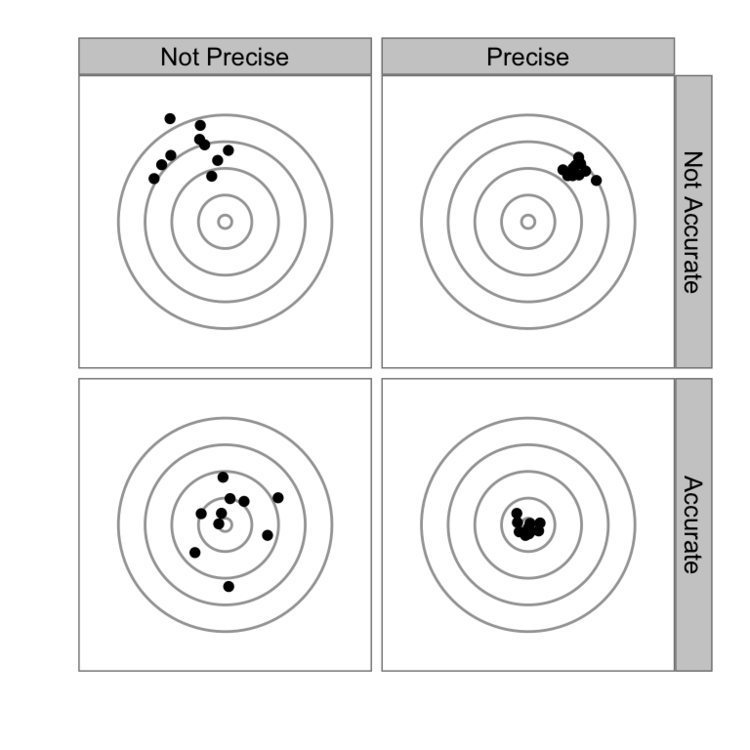

In [ ]:
hiper_k_rango = range(1,30)
scores=[]
for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    resultados_kfold = cross_val_score(knn_model,inputs,targets,cv=RKFold,scoring='accuracy')
    scores.append(resultados_kfold.mean())

print(scores)

In [ ]:
boxplot(scores)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en 50 repeticiones 10-fold cross-validation")

A mayores otra cosa que se podría hacer es usar el modelo stratified de tal manera que conservemos las mismas proporciones que en el conjunto original como en este caso:

In [ ]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold

hiper_k_rango = range(1,30)
scores=[]
RKFold_stratified = RepeatedStratifiedKFold(n_splits=10,n_repeats=50)

for k in hiper_k_rango:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    resultados_kfold = cross_val_score(knn_model,inputs,targets,cv=RKFold_stratified,scoring='accuracy')
    scores.append(resultados_kfold.mean())
    
scores_media_Kfold = scores

print(scores)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hiper_k_rango,scores)
plt.xlabel("Valores de k")
plt.ylabel("Accuracy en 50 repeticiones 10-fold cross-validation")

Un punto a destacar es que debiemos de tener mucho cuidado cuando usemos un API, esta nos simplifica la vida pero debemos saber que es lo que se esta haciendo, ya que nos puede llevar a resultados erroneos. Por ejemplo, el método *RepeatedKFold* devuelve la media de las repeticiones para cada fold, no para cada experimento. Si las quisieramos tendráiamos que hacer nuestra propia función que no es muy difícil como se ve a continuación:

In [ ]:
import numpy as np
from sklearn.utils import shuffle

def cross_validate(model, x, y, folds=10, repeats=5):
    score = np.zeros((repeats, folds))
    x = np.array(x)
    for r in range(repeats):
        i=0
        print('Experimento número', str(r + 1), 'de', str(repeats))
        x,y = shuffle(x,y,random_state=r) 
        kf = KFold(n_splits=folds,random_state=i+1000,shuffle=True)
        for train_ind,test_ind in kf.split(x):
            print('Fold', i+1, 'de',folds)
            xtrain,ytrain = x[train_ind,:],y[train_ind]
            xtest,ytest = x[test_ind,:],y[test_ind]
            model.fit(xtrain, ytrain)
            score[r,i]=metrics.accuracy_score(model.predict(xtest), ytest)
            i+=1
        print('\nAccuracy del experimento:',str(np.mean(score[r, :])))
    print('\nResults:',str(score))
    print('Media:',str(np.mean(score)))
    print('Desviación:',str(np.std(score)))
    return score

score=cross_validate(knn_model, inputs, targets, folds=10, repeats=5)

In [ ]:
print(score)
boxplot(score)

Es un boxplot un poco grande pero quen nos da una idea bastante feaciente de como se hacomportado el modelo en cada uno folds teniendo en cuenta las repeticiones.

## Otros tipos de cross-valiadation
Estos son sólo los principales tipos de entrenamiento, pero existen otros. Entre los más comunes tendríamos:

1. 5x2 *Cross-validation*. En este caso se realiza un 2-cv pero se repite 5 veces el proceso de tal manera que tengamos 10 valores de test. En casos con pocos datos es uno de las mejores aproximaciones porque permite hacer contrates de hipotesis como el t-test. 

In [ ]:
from sklearn.model_selection import cross_val_score,RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
cv_5x2 = RepeatedKFold(n_splits=2,n_repeats=5)
scores = cross_val_score(knn, inputs, targets, cv=cv_5x2)

print(np.mean(scores))

2. *Leave-one-out (LOO)* es una aproximación en el que se aplica el cross-validation a nivel de dato dejando sólo un ejemplo fuera en que el modelo entrenado con el resto se lo juega a todo o nada. Tiende a ser demasiado optimista en los resultados si las muestras no están balanceadas, pero es una opción cuando hay muy pocos datos. En la librería se encuentra implementado en la clase `LeaveOneOut`.

In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
loo = LeaveOneOut()
scores = cross_val_score(knn, inputs, targets, cv=loo)

print(np.mean(scores))

3. Nested Cross Valiadation. En este caso se hace un cross-validation para cada conjunto de entrenamiento del cross-validation. Es particularmente útil para evitar sesgos a la hora de comparar Modelos con diferentes configuraciones. El interno nos permite seleccionar los parámetros y el externo nos da una ideal del rendimiento general del modelo

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

knn = KNeighborsClassifier()

outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_scores = []
for train_index, test_index in outer_cv.split(inputs):
    inputs_train, inputs_test = inputs[train_index], inputs[test_index]
    targets_train, targets_test = targets[train_index], targets[test_index]
    inner_scores = cross_val_score(knn, inputs_train, targets_train, cv=inner_cv)
    nested_score = np.mean(inner_scores)
    nested_scores.append(nested_score)

print(np.mean(nested_scores))

4. Individual-wise o Group-wise cross-validation. En este caso concreto se tiene en cuenta el como están repartidas las muestras si, por ejemplo, son medidas sobre un mismo individuo en dos momentos diferentes. En dicho caso todas las muestras en el cross-validation debieran de ir a la misma partición porque, de otra manera, habría contaminación cruzada entre los conjuntos de entrenamiento y test.

In [ ]:
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

#Necesario generarlos artificialmente para el ejemplo
groups = np.zeros(len(inputs))
groups[:(len(inputs)//2)] = 1
knn = KNeighborsClassifier()

cv = GroupKFold(n_splits=2)
scores = cross_val_score(knn, inputs, targets, groups=groups, cv=cv)
print(scores)

# Resumiendo:
* Los modelos generados solamente con una división de los datos en dos bloques (entrenamiento y test) tienden a generar resultados muy optimistas, no generalizan bien. Se conoce este fenómeno como *data snooping bias*
* Un modelo generado mediante alguna aproximación de validación cruzada (la más típica es 10-fold aunque dependiendo del tamaño de los datos se podría aplicar, por ejemplo, una LOO por ejemplo) generaliza mejor
* Para estar seguros de que los resultados del modelo y su capacidad de generalización es adecuada, se repiten los experimentos k-fold varias veces (permutando/randomizando el reparto de los ejemplos) y se estudia su variabilidad. Produce una estimación más real reduciendo la varianza de los resultados
* Es más, lo ideal es hacer muchas repeticiones y estratificar los datos en el conjunto de validación.
* En la medida de lo posible y en función del tamaño del dataset. Reserva, previo al proceso de cross-validation, una proporción de los datos para validación previa a puesta en producción. Se conoce como *hold-out test*. Esta es una estimación real del funcionamiento del modelo, pero en caso de una mala generalización del modelo no se debe usar para ajustar los siguientes modelos a ese conjunto específico.
* Veremos más adelante en el curso diferenes aproximaciones de reducción de dimensionalidad. Normalmente, la selección de características o *feature selection* se realiza previamente a cross-validation. En lugar de eso, es más recomendable realizarlo dentro de cada iteración de cross validation, ya que el rendimiento es más parecido al que nos encontraremos al usar el modelo sobre datos externos no conocidos.